In [1]:
SCREEN = "20250216_AWALS37_Full_screen_n96"
ANALYSIS = "binary_loocv"
MARKERS = "all"

In [2]:
import json
import pickle
import pandas as pd
from pathlib import Path
from maps.screens import ImageScreenMultiAntibody

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/pipelines/params")
with open(pdir / f"{ANALYSIS}.json", "r") as f:
    params = json.load(f)

params["screen"] = SCREEN
params["antibodies"] = [
    a.replace("/atubulin", "") for a in params["antibodies"]
]

# initialize key mapping cell lines to mutations
screen = ImageScreenMultiAntibody(params)
plate_dirs = screen.loader._get_plate_dirs()
metadata = screen.loader.load_metadata(plate_dirs[0])
cellline_to_mutation = dict(zip(metadata["CellLines"], metadata["Mutations"]))

# load in analysis results
output_dir = Path(params.get("result_dir")) / params.get("screen")
with open(output_dir / f"{ANALYSIS}-{MARKERS}.pkl", "rb") as f:
    results = pickle.load(f)

map_analysis = results["analysis"]

# load in cell line metdata
mdir = Path("/awlab/projects/2024_ALS/data/cell_lines")
metadata = pd.read_csv(mdir / "FibroblastCellLine_cleaned.csv")
cellline_to_age = metadata.set_index("CellLines")["AgeOfBiopsy"].to_dict()

# i-MAP score visualizations

In [3]:
df_list = []
for genetics, val in map_analysis.fitted.items():
    df = val["predicted"].to_pandas()
    df["ModelGenetics"] = genetics
    df_list.append(df)
    
predictions = pd.concat(df_list)
predictions["Mutations"] = predictions["CellLines"].map(cellline_to_mutation)
predictions = (
    predictions.groupby(["CellLines", "Mutations", "ModelGenetics"])
    .mean()
    .reset_index()
)

For each genetic background `g`, order cell lines within that background by i-MAP scores from a `g` vs WT classifier. For WT and sporadic cell lines, order cell lines by the average i-MAP score across all `g` vs WT classifiers.

In [5]:
from collections import OrderedDict

# Recreate ordered cell lines block
cellline_means = (
    predictions.groupby(["Mutations", "CellLines"])["Class_1"]
    .mean()
    .reset_index()
)

all_groups = cellline_means["Mutations"].unique().tolist()
model_groups = [g for g in all_groups if g not in ["WT", "sporadic"]]

ordered_celllines = []
cellline_to_group = {}

for mutation in all_groups:
    group = cellline_means[cellline_means["Mutations"] == mutation]
    if mutation in model_groups:
        # Order by prediction for that group 
        relevant_cells = predictions[
            (predictions["ModelGenetics"] == mutation) & (predictions["Mutations"] == mutation)
        ]
        
        ordered = (
            relevant_cells.groupby("CellLines")["Class_1"]
            .mean()
            .reset_index()
            .sort_values("Class_1", ascending=False)["CellLines"]
            .tolist()
        )
        
        missing = [c for c in group["CellLines"] if c not in ordered]
        ordered += missing
    else:
        # WT and sporadic: order by mean prediction over all groups
        mean_preds = predictions[
            predictions["CellLines"].isin(group["CellLines"])
        ]
        
        ordered = (
            mean_preds.groupby("CellLines")["Class_1"]
            .mean()
            .reset_index()
            .sort_values("Class_1", ascending=False)["CellLines"]
            .tolist()
        )
        
    ordered_celllines.extend(ordered)
    for cellline in ordered:
        cellline_to_group[cellline] = mutation

# Remove duplicates while preserving order
ordered_celllines = list(OrderedDict.fromkeys(ordered_celllines))

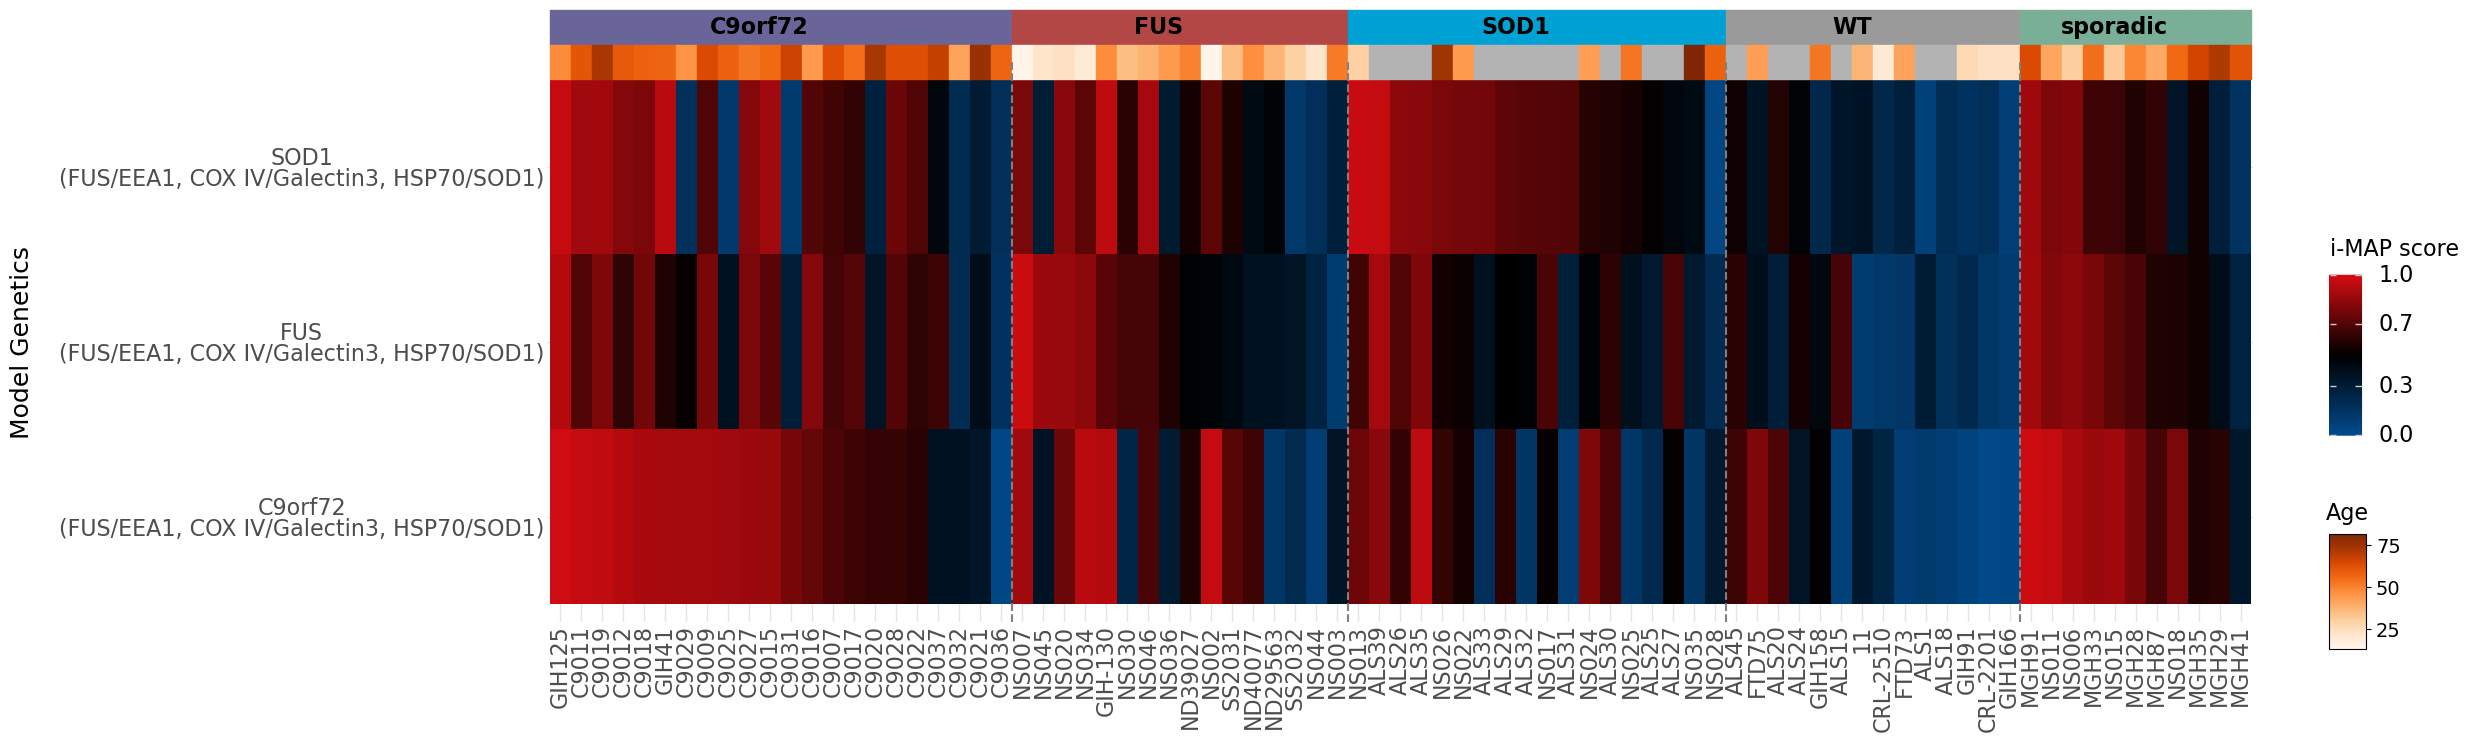

<Figure size 640x480 with 0 Axes>

In [6]:
import plotnine as p9
import matplotlib.pyplot as plt
from maps.figures import PALETTE


p9.theme_set(p9.theme_minimal())

# Prepare data for plotnine
plot_df = predictions.copy()
antibodies = ", ".join(params["antibodies"])
plot_df["Group"] = plot_df["Mutations"]
plot_df["ModelGenetics"] = plot_df["ModelGenetics"] + f"\n({antibodies})" 
plot_df["CellLines"] = pd.Categorical(
    plot_df["CellLines"], categories=ordered_celllines, ordered=True
)

# Compute group boundaries for vertical lines and group labels
group_labels = [cellline_to_group.get(cl, "") for cl in ordered_celllines]
unique_groups = []
group_positions = []
for i, group in enumerate(group_labels):
    if i == 0 or group != group_labels[i-1]:
        unique_groups.append(group)
        group_positions.append(i)

group_positions.append(len(group_labels))
group_centers = [
    (group_positions[i] + group_positions[i+1] - 1) / 2 
    for i in range(len(unique_groups))
]

# Cap figure size to avoid PlotnineError
max_width = 25
fig_width = min(len(ordered_celllines) * 0.4 + 4, max_width)
fig_height = min(len(plot_df["ModelGenetics"].unique()) * 0.4 + 6, 12)

# Plot heatmap using plotnine
heatmap_plot = (
    p9.ggplot(
        plot_df, 
        p9.aes(x='CellLines', y='ModelGenetics', fill='Class_1')
    ) +
    p9.geom_tile() +
    p9.scale_fill_gradient2(
        low='#014B8D', 
        mid='#000000', 
        high='#D40C11', 
        midpoint=0.5, 
        limits=(0,1),
        breaks=[0, 0.3, 0.7, 1],
        labels=['0.0', '0.3', '0.7', '1.0']
    ) +
    p9.theme(
        axis_text_x=p9.element_text(angle=90, size=16),
        axis_text_y=p9.element_text(size=16),
        axis_title_y=p9.element_text(size=18),
        axis_title_x=p9.element_blank(),
        legend_text=p9.element_text(size=16),
        legend_title=p9.element_text(size=16),
        plot_title=p9.element_text(size=16),
        figure_size=(fig_width, fig_height),
        legend_position='right'
    ) +
    p9.labs(y='Model Genetics', fill="i-MAP score") + 
    p9.theme(axis_title_x=p9.element_blank())
)

# Draw plotnine plot and add colorbar above using matplotlib
fig = heatmap_plot.draw()

# Add top colorbar for mutation groups above the axes
ax = fig.axes[0]
col_colors = [PALETTE.get(grp, '#ffffff') for grp in group_labels]
bar_height = 0.2
mutation_bar_y = 3.7
age_bar_y = 3.5

# Mutation strip
for i, color in enumerate(col_colors):
    ax.add_patch(plt.Rectangle((i + 0.5, mutation_bar_y), 1, bar_height, color=color, transform=ax.transData, clip_on=False, zorder=2))

# Add group names centered in the mutation color bar
for i, center in enumerate(group_centers):
    ax.text(center, mutation_bar_y + bar_height/2, unique_groups[i], ha='center', va='center', fontsize=16, color='black', fontweight='bold', transform=ax.transData, zorder=3)

# Age strip - map ages to continuous green shades
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

ages = [cellline_to_age.get(cl, np.nan) for cl in ordered_celllines]
valid_ages = [a for a in ages if not np.isnan(a)]

if len(valid_ages) > 0:
    min_age = min(valid_ages)
    max_age = max(valid_ages)
    
    # Create a green colormap (light green to dark green)
    cmap = cm.Oranges
    norm = Normalize(vmin=min_age, vmax=max_age)
    
    for i, age in enumerate(ages):
        if not np.isnan(age):
            color = cmap(norm(age))
        else:
            color = (0.7, 0.7, 0.7)  # Grey for missing ages
        ax.add_patch(plt.Rectangle((i + 0.5, age_bar_y), 1, bar_height, color=color, transform=ax.transData, clip_on=False, zorder=2))

# Add vertical grey lines to separate groups in heatmap and color bars
for pos in group_positions[1:-1]:
    ax.axvline(pos + 0.5, color='grey', linestyle='--', linewidth=1.5, zorder=2)

# Add age colorbar legend
from matplotlib.patches import Patch

# Get the existing legend (i-MAP score legend from plotnine)
existing_legend = ax.get_legend()

if len(valid_ages) > 0:
    # Add grey patch for missing data in legend first
    age_legend_elements = [Patch(facecolor=(0.7, 0.7, 0.7), label='Missing')]
    age_legend = ax.legend(handles=age_legend_elements, title='Age', 
                           loc='upper left', bbox_to_anchor=(1.15, 0.35),
                           frameon=True, fontsize=10, title_fontsize=12)
    ax.add_artist(age_legend)
    
    # Create a colorbar using figure coordinates for precise positioning
    # [left, bottom, width, height]
    cax = fig.add_axes([0.9375, 0.15, 0.015, 0.16])
    
    # Create the colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.ax.set_title('Age', fontsize=16, pad=10)
    cbar.ax.tick_params(labelsize=14)

# Add back the existing legend
if existing_legend is not None:
    ax.add_artist(existing_legend)

fig.subplots_adjust(top=0.92, right=0.85)
display(fig)

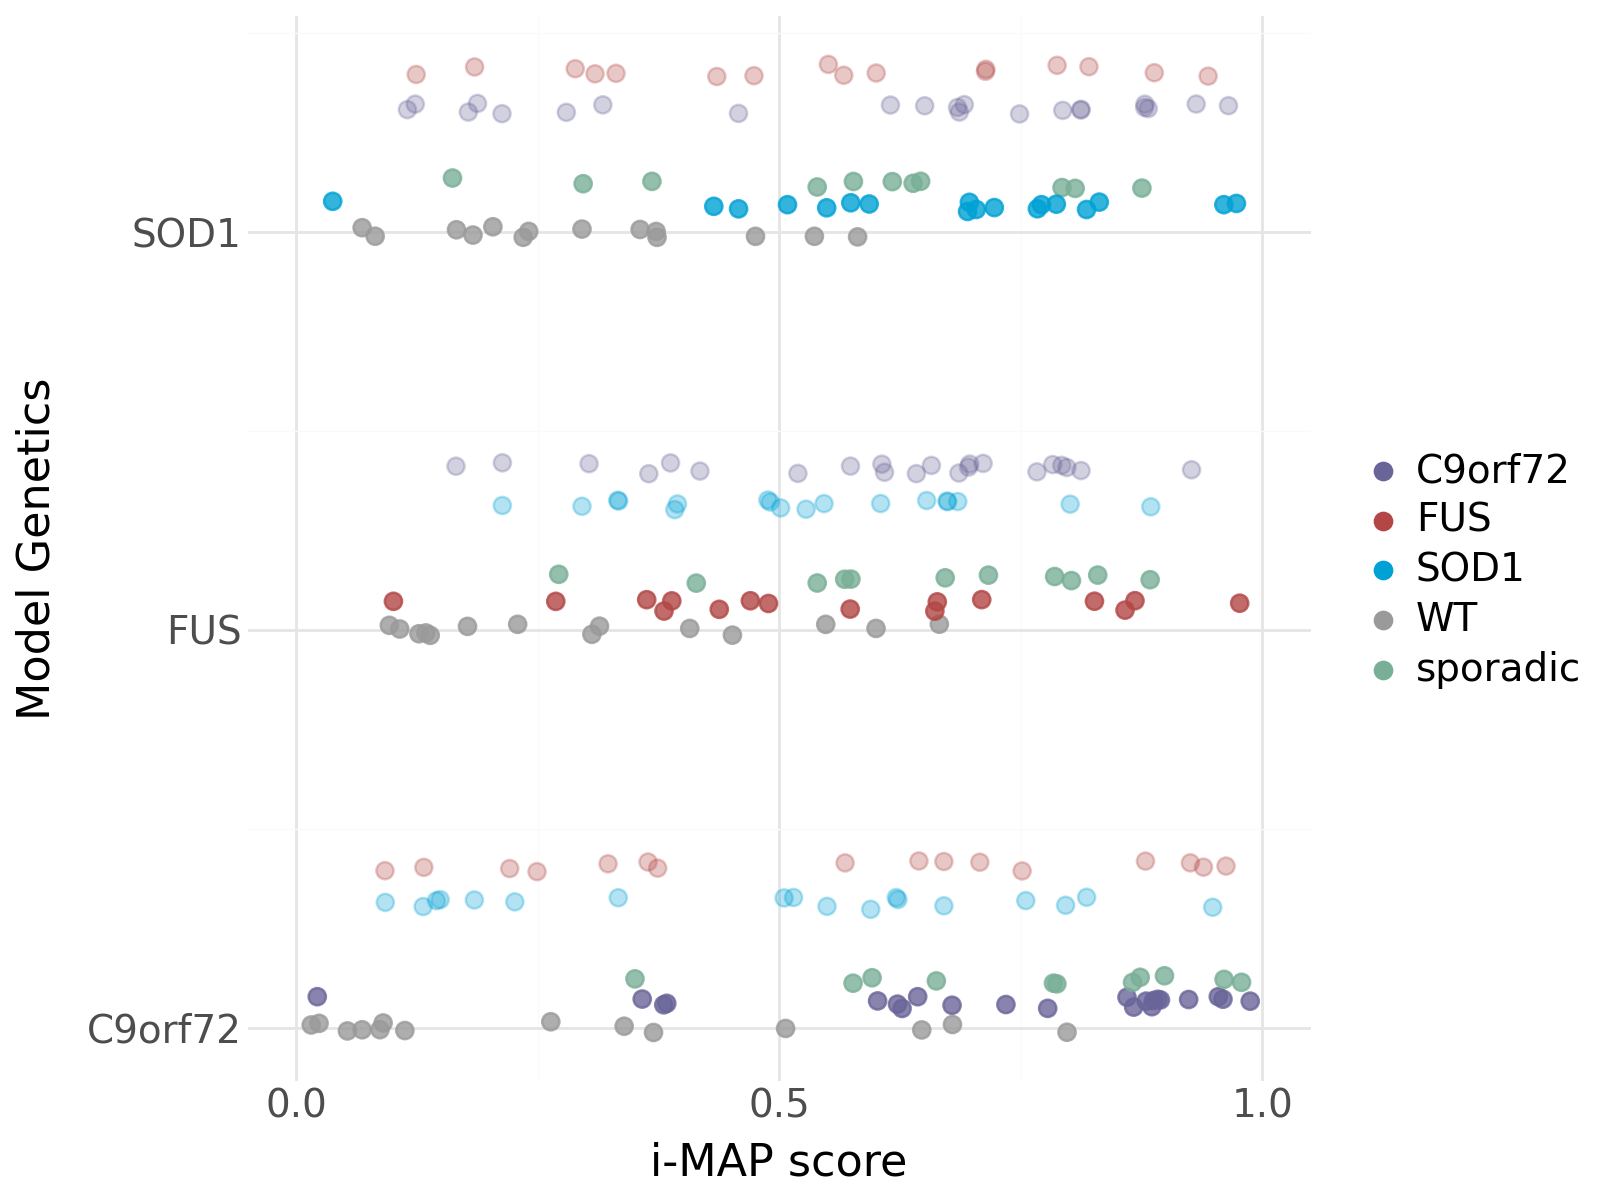

In [ ]:
import plotnine as p9
import numpy as np

# Prepare data for scatter plot
scatter_df = predictions.copy()
scatter_df["MutationColor"] = scatter_df["Mutations"].map(PALETTE)
scatter_df["i-MAP score"] = scatter_df["Class_1"]

# Create model order mapping
model_order = {
    gen: i for i, gen in enumerate(scatter_df['ModelGenetics'].unique())
}

scatter_df['y_numeric'] = scatter_df['ModelGenetics'].map(model_order)

# For each model genetics, create custom mutation ordering
# Order: WT (bottom), model genetics, sporadic, gap, then other genetics
def get_mutation_position(row):
    model_gen = row['ModelGenetics']
    mutation = row['Mutations']
    
    # Get all unique mutations (excluding WT and sporadic)
    all_mutations = [m for m in scatter_df['Mutations'].unique() if m not in ['WT', 'sporadic']]
    
    if mutation == 'WT':
        return 0.0  # Bottom
    elif mutation == model_gen:
        return 0.2  # After WT
    elif mutation == 'sporadic':
        return 0.4  # After model genetics
    else:
        # Other genetics - add larger gap and then distribute
        other_genetics = [m for m in all_mutations if m != model_gen]
        if mutation in other_genetics:
            idx = other_genetics.index(mutation)
            # Start after a larger gap (at 1.0) and spread them out
            return 1.0 + (idx * 0.3)
        else:
            return 1.0

scatter_df['mutation_position'] = scatter_df.apply(get_mutation_position, axis=1)

# Add small random jitter for visibility
scatter_df['mutation_jitter'] = scatter_df['mutation_position'] + np.random.uniform(
    -0.05, 0.05, size=len(scatter_df))

# Compress rows by scaling y_numeric (reduces gap between rows)
# and keep mutation spread within rows by scaling mutation_jitter
scatter_df['y_jitter'] = scatter_df['y_numeric'] * 0.8 + scatter_df['mutation_jitter'] * 0.25

# Set alpha based on whether mutation is primary (WT, model genetics, sporadic) or other
def get_alpha(row):
    model_gen = row['ModelGenetics']
    mutation = row['Mutations']
    if mutation in ['WT', 'sporadic'] or mutation == model_gen:
        return 0.8  # Primary groups
    else:
        return 0.3  # Other genetics

scatter_df['point_alpha'] = scatter_df.apply(get_alpha, axis=1)

# Plot using plotnine
scatter_plot = (
    p9.ggplot(scatter_df, 
        p9.aes(x='i-MAP score', y='y_jitter', color='Mutations', alpha='point_alpha')
    ) +
    p9.geom_point(size=3) +
    p9.scale_color_manual(values=PALETTE) +
    p9.scale_alpha_identity() + 
    p9.scale_x_continuous(limits=(0, 1), breaks=[0, 0.5, 1]) +
    p9.scale_y_continuous(
        breaks=[i * 0.8 for i in model_order.values()], 
        labels=list(model_order.keys())
    ) +
    p9.theme(
        axis_text_x=p9.element_text(size=14),
        axis_text_y=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=16),
        axis_title_y=p9.element_text(size=16),
        legend_text=p9.element_text(size=14),
        legend_title=p9.element_text(size=14),
        plot_title=p9.element_text(size=16),
        figure_size=(8, 6),
        legend_position='right'
    ) +
    p9.labs(
        x='i-MAP score', 
        y='Model Genetics', 
        color='', 
    ) +
    p9.theme(axis_title_y=p9.element_text(margin={'r': 10}))
)

display(scatter_plot)